# Results analysis

#### dataset Loading and options 

In [30]:
from datasets import Dataset,load_dataset
import pandas as pd
import seaborn as sb

dataset_split = ["simpleLLM_benchmark_llama3.18binstant_t_0.7"][0]

dataset = load_dataset("CharlyR/varbench-evaluation", "tikz", split=dataset_split)

result_df = dataset.to_pandas()

In [31]:
#filtering by having a result
filtered_df = result_df[result_df['index_best_prediction']!= -1]
filtered_df

,id,code,instruction,result_description,difficulty,patch,code_solution,image_solution,image_input,predictions,...,best_ChrfMetric,best_LPIPSMetric,best_FeatureMatchMetric,best_ClipTextMetric,best_LineMetric,best_MSSSIMMetric,best_TERMetric,best_PSNRMetric,best_BleuMetric,best_ClipImageMetric
0,donkey_higher_mane,"\documentclass[tikz,border=5]{standalone}\n\us...",Make the mane of the donkey go upward a little...,A donkey with a high mane over its head,hard,"@@ -61,2 +61,2 @@\n- to [bend left] ++( 16, ...","\documentclass[tikz,border=5]{standalone}\n\us...",{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[\documentclass[tikz,border=5]{standalone}\n\u...",...,98.825668,99.587547,58.441559,22.200275,0.0,97.173920,97.784813,45.181442,97.864990,99.859177
1,chimpanzee_squint_crosseyes,"\documentclass[tikz,border=5]{standalone}\n\us...","Make the eyes of the chimpanzee crossed, by ma...",A crossed-eyes chimpanzee,medium,"@@ -29,2 +29,4 @@\n-\foreach \i in {-1,1}- \f...","\documentclass[tikz,border=5]{standalone}\n\us...",{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[\documentclass[tikz,border=5]{standalone}\n\u...",...,92.254700,97.354042,62.162163,24.784460,0.0,88.227509,83.606560,43.536983,87.232475,95.021492
2,bee_red_stripes,"\documentclass[tikz,border=5]{standalone}\n\us...",Change the color of the stripes to red,A bee with red stripes,easy,"@@ -25,2 +25,2 @@\n- on left= {colors alias={...","\documentclass[tikz,border=5]{standalone}\n\us...",{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[\documentclass[tikz,border=5]{standalone}\n\u...",...,100.000000,100.000000,100.000000,27.442713,100.0,100.000000,100.000000,100.000000,100.000000,100.000000
3,shark_no_teeth,"\documentclass[tikz,border=5]{standalone}\n\us...",Remove the teeth of the shark,A shark with no teeth,easy,"@@ -7,6 +6,0 @@\n-\fill [BlueGrey200]- (2,16....","\documentclass[tikz,border=5]{standalone}\n\us...",{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[\documentclass[tikz,border=5]{standalone}\n\u...",...,96.587357,99.756622,93.478264,25.336811,0.0,99.631050,73.140495,54.558231,82.990738,99.376839
4,shark_other_set_pectoral_fin,"\documentclass[tikz,border=5]{standalone}\n\us...","Add another set of pectoral fin to the shark, ...",A shark with two sets of pectoral fins,hard,"@@ -16,0 +17,6 @@\n+\fill [BlueGrey700] (11,10...","\documentclass[tikz,border=5]{standalone}\n\us...",{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[\documentclass[tikz,border=5]{standalone}\n\u...",...,88.865723,97.826614,72.580643,26.552582,0.0,96.847328,80.606064,48.234116,87.083885,99.555634
5,dog_red_eyes,"\documentclass[tikz,border=5]{standalone}\n\us...",Change the colors of the dog's eyes to red,A dog with red eyes,easy,"@@ -51 +51 @@\n- \fill [BlueGrey900] (56, 0) ...","\documentclass[tikz,border=5]{standalone}\n\us...",{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[\documentclass[tikz,border=5]{standalone}\n\u...",...,98.480247,97.825569,58.064518,23.243683,0.0,94.849579,91.463417,47.829006,92.416550,96.871613
7,squid_bigger_eyes,"\documentclass[tikz,border=5]{standalone}\n\us...",Make the eyes of the squid bigger,A squid with big roud eyes,medium,"@@ -38,3 +38,3 @@\n- \fill [fill color] (64,...","\documentclass[tikz,border=5]{standalone}\n\us...",{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[\documentclass[tikz,border=5]{standalone}\n\u...",...,99.134972,97.081902,38.554218,25.911617,0.0,87.443787,98.319328,41.423878,98.726082,99.514008
8,chimpanzee_blue_fur,"\documentclass[tikz,border=5]{standalone}\n\us...",Change the color of the chimpanzee's fur to blue,A chimpanzee with blue fur,easy,@@ -7 +7 @@\n-\fill 

In [34]:
filtered_df = filtered_df.select_dtypes(include=["int","float"])
filtered_df = filtered_df.drop(["compiling_score","parsing_score","index_best_prediction"],axis=1)
filtered_df

,var_score,best_ChrfMetric,best_LPIPSMetric,best_FeatureMatchMetric,best_ClipTextMetric,best_LineMetric,best_MSSSIMMetric,best_TERMetric,best_PSNRMetric,best_BleuMetric,best_ClipImageMetric
0,71.691939,98.825668,99.587547,58.441559,22.200275,0.0,97.173920,97.784813,45.181442,97.864990,99.859177
1,67.418038,92.254700,97.354042,62.162163,24.784460,0.0,88.227509,83.606560,43.536983,87.232475,95.021492
2,92.744271,100.000000,100.000000,100.000000,27.442713,100.0,100.000000,100.000000,100.000000,100.000000,100.000000
3,72.485641,96.587357,99.756622,93.478264,25.336811,0.0,99.631050,73.140495,54.558231,82.990738,99.376839
4,69.815259,88.865723,97.826614,72.580643,26.552582,0.0,96.847328,80.606064,48.234116,87.083885,99.555634
5,70.104418,98.480247,97.825569,58.064518,23.243683,0.0,94.849579,91.463417,47.829006,92.416550,96.871613
7,68.610979,99.134972,97.081902,38.554218,25.911617,0.0,87.443787,98.319328,41.423878,98.726082,99.514008
8,66.458591,96.893456,95.388031,40.000000,28.118896,0.0,82.164673,96.022728,35.607243,97.141411,93.249474
9,73.270054,97.752525,99.599823,76.744186,25.674559,0.0,97.883102,94.174759,44.334419,97.169106,99.368057
11,68.077737,97.637932,93.318367,35.555557,26.930805,50.0,57.195900,93.577980,35.269596,95.573929,95.717300


<Axes: >

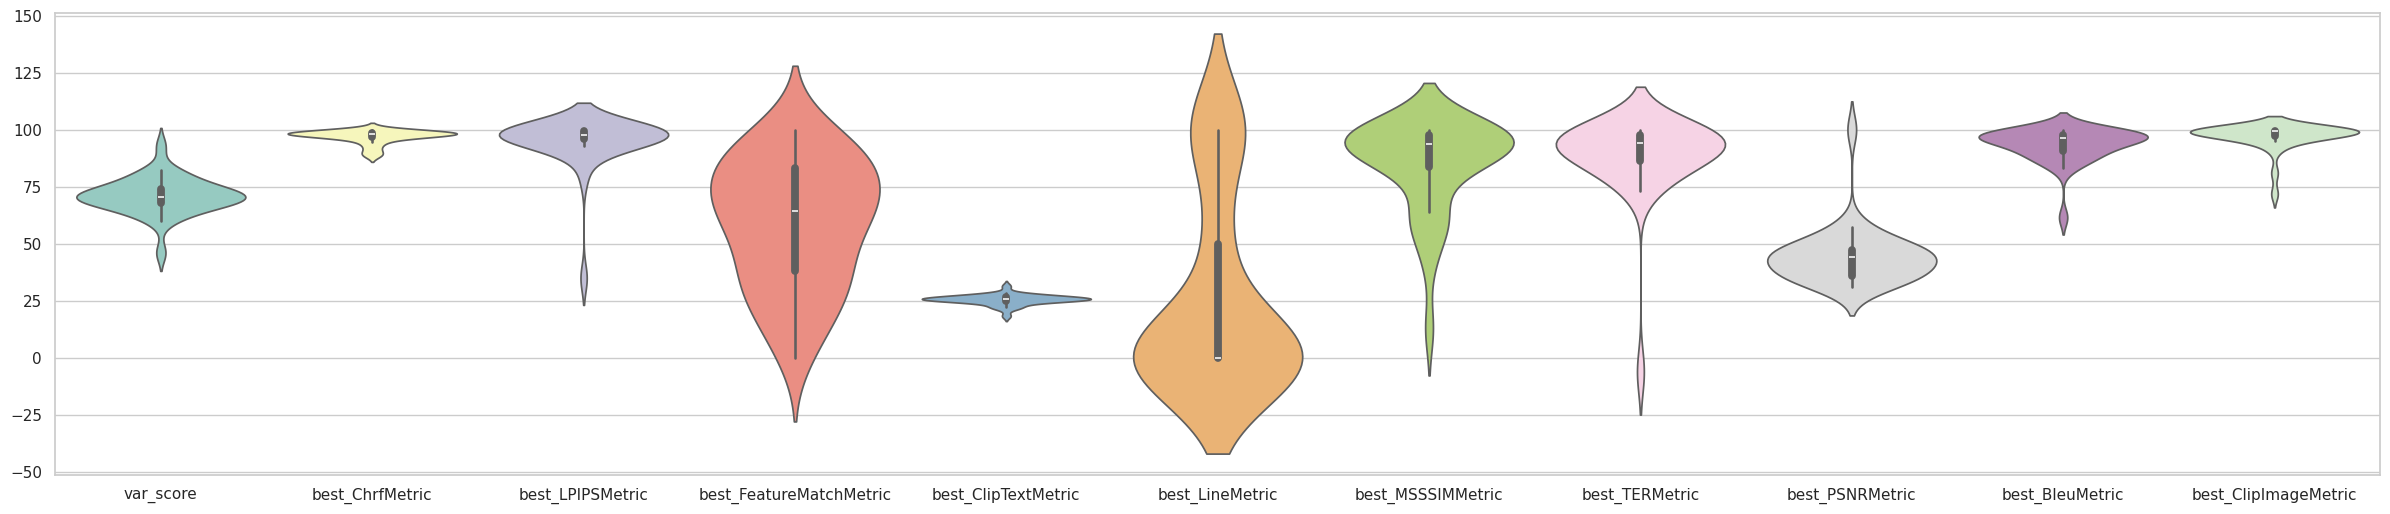

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Load the example dataset of brain network correlations
df = filtered_df

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 6))

# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=df, palette="Set3")
